<a href="https://colab.research.google.com/github/sonashukoor/ml-projects/blob/main/CNN_Hot_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

##Citation

@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}

##Data

TensorFlow has the food 101 dataset already. Using this here! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Q40HEJ_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Q40HEJ_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [25]:
train_ds, valid_ds = ds["train"], ds["validation"]

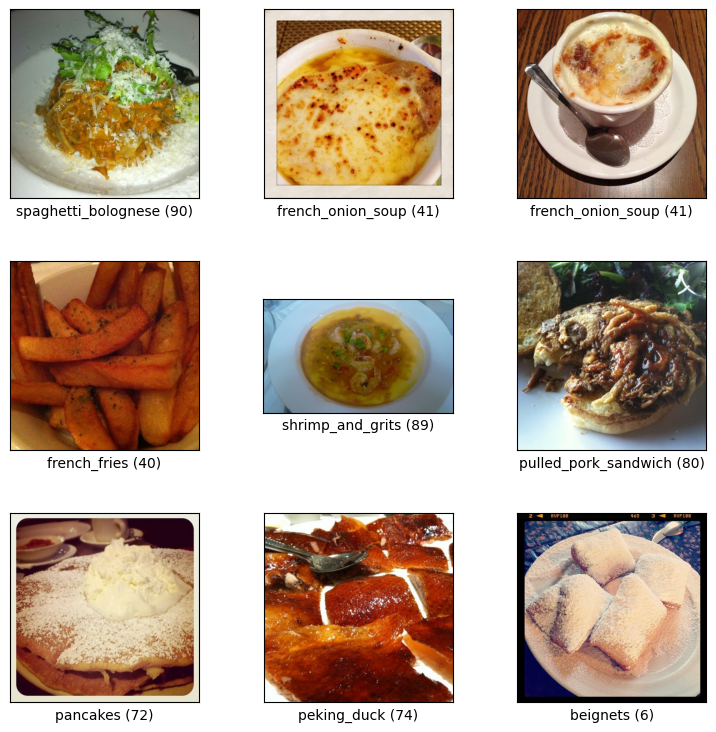

In [24]:
fig = tfds.show_examples(train_ds, ds_info)

In [26]:
#resize to make it to same size & cast labels
#1 - hotdog, 0 - not hotdog
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)


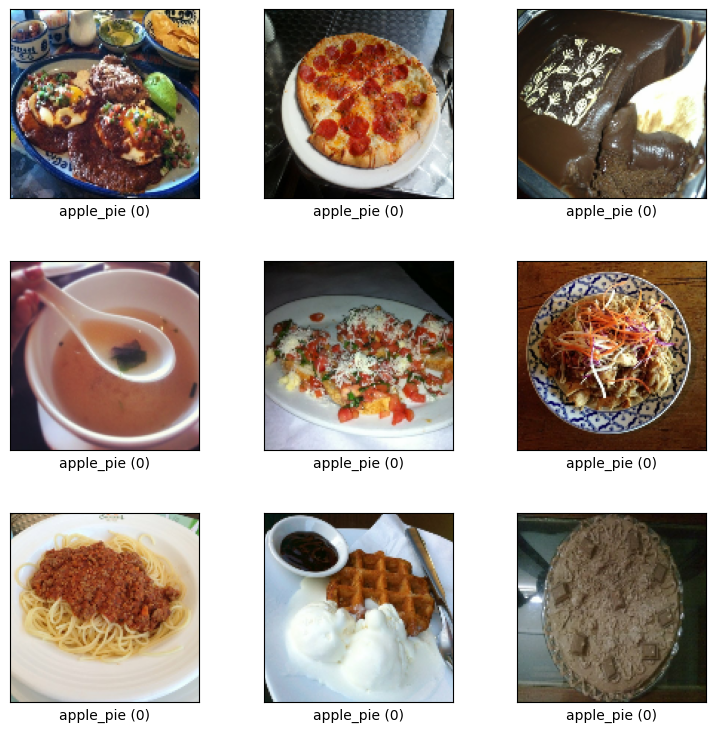

In [27]:
fig = tfds.show_examples(train_ds, ds_info)

In [28]:
#increase the hotdog dataset size

train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [29]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [30]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE) #cache-storage, prefetch- fetch next while another executing

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [33]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[211 192 166]
   [209 191 170]
   [219 208 187]
   ...
   [216 205 181]
   [205 192 167]
   [212 197 172]]

  [[202 186 159]
   [207 192 168]
   [210 199 177]
   ...
   [220 210 189]
   [205 193 169]
   [213 199 173]]

  [[201 186 160]
   [214 201 180]
   [214 202 183]
   ...
   [218 209 191]
   [215 204 182]
   [213 200 175]]

  ...

  [[232 224 211]
   [233 225 215]
   [234 225 216]
   ...
   [231 222 210]
   [230 220 207]
   [230 218 203]]

  [[233 225 208]
   [230 221 209]
   [234 225 216]
   ...
   [228 219 208]
   [232 223 209]
   [233 221 206]]

  [[234 226 207]
   [236 226 213]
   [235 225 216]
   ...
   [231 222 210]
   [233 223 210]
   [232 220 205]]]


 [[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]


#Neural Network Implementation

In [60]:
#data augmentation - change data while entering into the model

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

In [59]:
# #check what data augmentation does
# for i, _ in ds["train"].take(1):
#   image = i

In [58]:
# plt.imshow(image)

In [57]:
# image = tf.cast(tf.expand_dims(image, 0), tf.float32)
# image /= 255.0

In [56]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

In [61]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255)) #rescale images to 0(black) to 1(white)
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3))) #(3,3)-size of filter
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # or tf.keras.regularizers.l2(l2=0.01)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # or tf.keras.regularizers.l2(l2=0.01)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) #each input goes to all nodes
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1)) #Node to tell 0 or 1

#overtraining data - accuracy decrease for unseen data
#dropout some layers, randomize
#kernel regularise weights

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
lr = 0.0001 #learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
    279/Unknown 637s 2s/step - accuracy: 0.4895 - loss: 1.5980

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


279/279 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - accuracy: 0.4895 - loss: 1.5975 - val_accuracy: 0.4838 - val_loss: 1.1869
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 278s 931ms/step - accuracy: 0.5002 - loss: 1.1080 - val_accuracy: 0.5114 - val_loss: 0.9255
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 260s 931ms/step - accuracy: 0.5254 - loss: 0.9020 - val_accuracy: 0.5182 - val_loss: 0.8175
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 269s 966ms/step - accuracy: 0.5433 - loss: 0.8089 - val_accuracy: 0.5843 - val_loss: 0.7574
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 260s 934ms/step - accuracy: 0.5594 - loss: 0.7607 - val_accuracy: 0.6215 - val_loss: 0.7243
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 269s 963ms/step - accuracy: 0.5702 - loss: 0.7335 - val_accuracy: 0.6050 - val_loss: 0.7016
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 262s 941ms/step - accuracy: 0.5618 - loss: 0.7169 - val_accuracy: 0.6118 - val_loss: 0.6846
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 265s 951ms/step - accuracy: 0.5733 - loss: 0.7024 

In [64]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

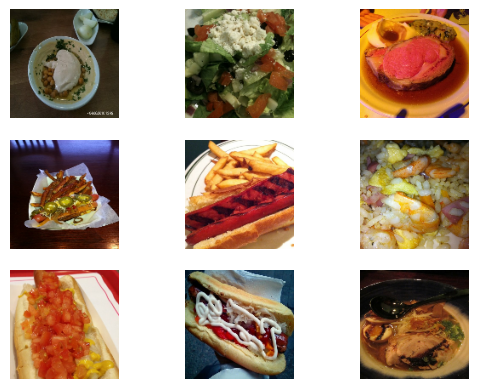

In [65]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [66]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 0, 1, 1, 0, 1, 1, 0], dtype=int32)>